## Exploration of land plots transaction data

In [51]:
import duckdb
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from shapely import wkb, wkt

#### 1. Connecting to the already built DB

In [2]:
con = duckdb.connect("plots_poland.duckdb")

In [3]:
con.execute("LOAD spatial")

#### 2. Getting transaction data

In [4]:
transactions_df = con.execute(''' 
    SELECT * FROM transactions
    LIMIT 5
''').df()

In [5]:
transactions_df.T

,0,1,2,3,4
serwis_rcn,https://piaseczynski.rciwn.pl,https://piaseczynski.rciwn.pl,https://piaseczynski.rciwn.pl,https://piaseczynski.rciwn.pl,https://piaseczynski.rciwn.pl
teryt,1418,1418,1418,1418,1418
lokalny_id,517047326,517055662,517056942,517055854,517060309
data_transakcji,2023-09-01,2024-12-14,2025-03-06,2024-12-16,2025-10-30
rodzaj_transakcji,wolnyRynek,wolnyRynek,wolnyRynek,wolnyRynek,wolnyRynek
rodzaj_nieruchomosci,nieruchomoscGruntowaZabudowana,nieruchomoscGruntowaZabudowana,nieruchomoscGruntowaZabudowana,nieruchomoscGruntowaZabudowana,nieruchomoscGruntowaZabudowana
link,https://piaseczynski.rciwn.pl/?identyfikatory=...,https://piaseczynski.rciwn.pl/?identyfikatory=...,https://piaseczynski.rciwn.pl/?identyfikatory=...,https://piaseczynski.rciwn.pl/?identyfikatory=...,https://piaseczynski.rciwn.pl/?identyfikatory=...
pozostale_atrybuty,"{""gml_id"": ""transakcje.517047326"", ""lowerCorne...","{""gml_id"": ""transakcje.517055662"", ""lowerCorne...","{""gml_id"": ""transakcje.517056942"", ""lowerCorne...","{""gml_id"": ""transakcje.517055854"", ""lowerCorne...","{""gml_id"": ""transakcje.517060309"", ""lowerCorne..."
czas_pozyskania,2026-01-30 23:01,2026-01-30 23:01,2026-01-30 23:01,2026-01-30 23:01,2026-01-30 23:01
geometry,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."


Let's check if transactions have any duplicates - identical rows

In [6]:
dupl_transactions_df = con.execute(''' 
    SELECT *, COUNT(*) AS cnt
    FROM transactions
    GROUP BY *
    HAVING COUNT(*) > 1
''').df()

In [7]:
dupl_transactions_df

,serwis_rcn,teryt,lokalny_id,data_transakcji,rodzaj_transakcji,rodzaj_nieruchomosci,link,pozostale_atrybuty,czas_pozyskania,geometry,geometry_bbox,cnt


The municipality name is not conveniently available, so let's join it spatially from plots and at the same time limit the data to Warsaw + neighborhood

In [8]:
# in Poland districts have the rank of municipality
warsaw_districts = [
    "bemowo", "białołęka", "bielany", "mokotów", "ochota",
    "praga-południe", "praga-północ", "rembertów", "śródmieście",
    "targówek", "ursus", "ursynów", "wawer", "wesoła",
    "wilanów", "włochy", "wola", "żoliborz"
]

In [9]:
districts_condition = " OR ".join(
    f"LOWER(nazwa_gminy) LIKE '%{d}%'" for d in warsaw_districts
)

In [ ]:
warsaw_buffer_trans_df = con.execute(f'''                                  
    WITH warsaw_plots_buffer AS (
        SELECT nazwa_gminy, ST_Buffer(geometry, 1000) AS geometry
        FROM plots 
        WHERE {districts_condition}
    ),
    warsaw_buffer_municipalities AS (
        SELECT p.nazwa_gminy 
        FROM plots p
        JOIN warsaw_plots_buffer b
        ON ST_Intersects(p.geometry, b.geometry)
    )
    SELECT t.*, p.nazwa_gminy, p.id_dzialki
    FROM transactions t
    LEFT JOIN plots p
    ON ST_ContainsProperly(t.geometry, p.geometry)
    WHERE p.nazwa_gminy IN (SELECT DISTINCT nazwa_gminy FROM warsaw_buffer_municipalities)
''').df()

The above approach was quite slow, so instead I decided to directly use the list of names of municipalities surrounding Warsaw. (Later I came up with a better solution - using BDOT10k admin areas, see below)

In [10]:
municipalities_around_warsaw = [
    "łomianki", "izabelin", "stare babice", 
    "jabłonna", "nieporęt", "marki", "ząbki", "zielonka",
    "wiązowna", "halinów", "józefów", "ożarów mazowiecki",
    "konstancin-jeziorna", "piaseczno", "lesznowola",
    "raszyn", "michałowice", "pruszków", "piastów", "sulejówek"
]

In [11]:
all_municipalities = warsaw_districts + municipalities_around_warsaw

In [12]:
all_municipalities_condition = " OR ".join(
    f"LOWER(p.nazwa_gminy) LIKE '%{d}%'" for d in all_municipalities
)

In [13]:
all_municipalities_trans_df = con.execute(f''' 
    WITH transactions_with_id AS (
        SELECT 
            ROW_NUMBER() OVER () AS transaction_id,
            t.*
        FROM transactions t
    )
    SELECT td.*, p.nazwa_gminy, p.id_dzialki
    FROM transactions_with_id td
    LEFT JOIN plots p
    ON ST_ContainsProperly(p.geometry, td.geometry)
    WHERE {all_municipalities_condition}
''').df()

In [14]:
all_municipalities_trans_df.head().T

,0,1,2,3,4
transaction_id,164866,165564,165566,165530,166487
serwis_rcn,https://wolominski.rciwn.pl,https://minski.rciwn.pl,https://minski.rciwn.pl,https://minski.rciwn.pl,https://minski.rciwn.pl
teryt,1434,1412,1412,1412,1412
lokalny_id,77111,40023202,40036610,40029174,443
data_transakcji,2019-01-30,2021-02-22,2024-11-29,2022-09-20,2016-03-02
rodzaj_transakcji,wolnyRynek,wolnyRynek,wolnyRynek,wolnyRynek,wolnyRynek
rodzaj_nieruchomosci,nieruchomoscGruntowaZabudowana,nieruchomoscGruntowaNiezabudowana,nieruchomoscGruntowaNiezabudowana,nieruchomoscGruntowaNiezabudowana,nieruchomoscGruntowaZabudowana
link,https://wolominski.rciwn.pl/?identyfikatory=77111,https://minski.rciwn.pl/?identyfikatory=40023202,https://minski.rciwn.pl/?identyfikatory=40036610,https://minski.rciwn.pl/?identyfikatory=40029174,https://minski.rciwn.pl/?identyfikatory=443
pozostale_atrybuty,"{""gml_id"": ""transakcje.77111"", ""lowerCorner"": ...","{""gml_id"": ""transakcje.40023202"", ""lowerCorner...","{""gml_id"": ""transakcje.40036610"", ""lowerCorner...","{""gml_id"": ""transakcje.40029174"", ""lowerCorner...","{""gml_id"": ""transakcje.443"", ""lowerCorner"": ""4..."
czas_pozyskania,2026-01-30 23:02,2026-01-30 23:01,2026-01-30 23:01,2026-01-30 23:01,2026-01-30 23:01


In [15]:
len(all_municipalities_trans_df)

94326

In [16]:
all_municipalities_trans_df['nazwa_gminy'].value_counts(dropna=False)

nazwa_gminy
Piaseczno              31758
Lesznowola             18554
Marki                   8657
Konstancin-Jeziorna     7034
Ząbki                   6592
Pruszków                4683
Raszyn                  3601
gm. Żabia Wola          2890
Halinów                 2759
Sulejówek               2721
Zielonka                1750
Michałowice             1690
Piastów                 1637
Name: count, dtype: int64

It seems that there are no available transaction data for Warsaw itself, but selected municipalities located nearby e.g. Konstancin-Jeziorna, can be analyzed. I made the filtering to flexible so gm. Żabia Wola was added unnecessarily - let's remove it from the df.

In [17]:
all_municipalities_trans_df = all_municipalities_trans_df.loc[all_municipalities_trans_df['nazwa_gminy'] != 'gm. Żabia Wola']
len(all_municipalities_trans_df)

91436

More than 100k transactions were found.

#### 3. Identifiers & joins

By using the LEFT JOIN I made sure that I have all transactions, no matter if spatially corresponding plot exists or not. Let's check if such cases occured.

In [18]:
all_municipalities_trans_df["id_dzialki"].isna().any()

np.False_

Fortunately, they didn't.

It is still possible to get many-to-many join results: <br>
❌ one transaction should refer to one plot only - if it is joined to more than one, it means that probably plots have duplicates or other type of extent errors <br>
✅ one plot (id_dzialki) can be the subject of many transactions (several transaction types or it was just sold, sold again etc.) 

In [19]:
all_municipalities_trans_df["transaction_id"].duplicated().any()

np.False_

The first situation is not true, let's check the second one.

In [20]:
trans_per_plot_counts = all_municipalities_trans_df["id_dzialki"].value_counts()
trans_per_plot_counts

id_dzialki
142102_1.0023.524      475
141803_2.0032.20/3     395
141803_2.0032.8/15     315
141804_4.0003.17/12    312
141804_4.0011.6/3      290
                      ... 
142101_1.0002.588/4      1
142101_1.0002.87/9       1
142101_1.0002.466/8      1
142101_1.0002.288/1      1
142101_1.0002.274/1      1
Name: count, Length: 33036, dtype: int64

In [21]:
plots_with_trans_freq = trans_per_plot_counts.value_counts().sort_index()
plots_with_trans_freq

count
1      24097
2       4156
3       1314
4        674
5        450
       ...  
290        1
312        1
315        1
395        1
475        1
Name: count, Length: 135, dtype: int64

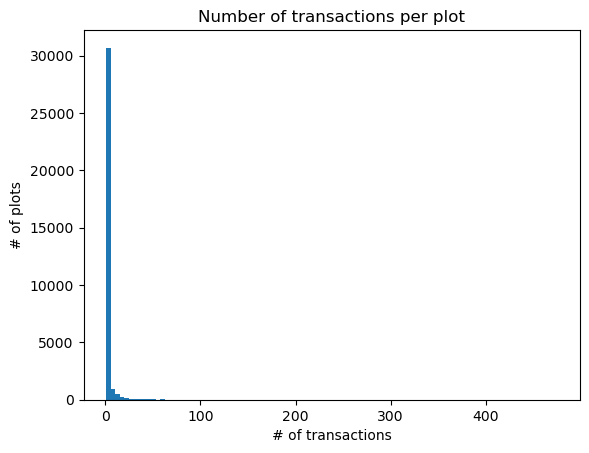

In [22]:
trans_per_plot_counts.plot.hist(bins=100)

plt.xlabel("# of transactions")
plt.ylabel("# of plots")
plt.title("Number of transactions per plot")
plt.show();

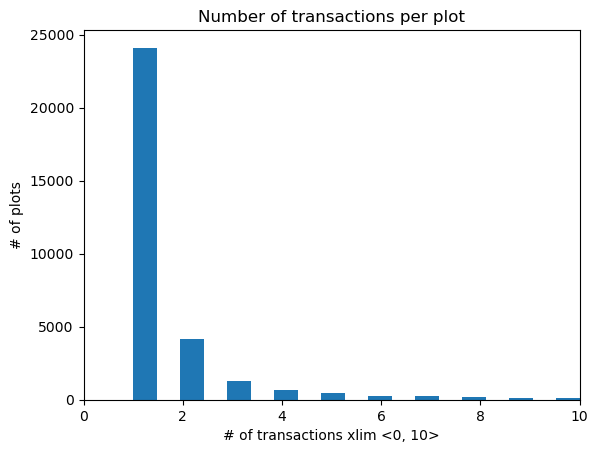

In [23]:
trans_per_plot_counts.plot.hist(bins=1000)

plt.xlabel("# of transactions xlim <0, 10>")
plt.ylabel("# of plots")
plt.title("Number of transactions per plot")
plt.xlim(0, 10)
plt.show();

Majority of plots is associated with one transaction. There are howover examples of plots with >400 transactions. The construction of multi-familty building is not too popular at the outskirts of Warsaw. They might however occur and >400 transaction situations most probably refer to them (developer buys a plot of land - 1st transaction, after the construction developer transfers the ownership to buyers).

There is one more interesting dimension of joining transactions to plots - plots might change in time (e.g. be divided). If my understanding is correct, EGIB DB that plots some from reflect the current reality, while transactions refer to the time of the transaction. Also, there is no id of the plot in the transaction table - this is why spatial join was needed. I however observed that transaction point geometry is defined as a centroid of the plot it refers to - in other words: if the transaction doesn't lay in the centroid of the current plot, most probably there was a plot change after the transaction occured. Let's check how often does it happen.

In [24]:
trans_with_correct_plot_df = con.execute(f''' 
    WITH plots_centroid_buffered AS (
        SELECT id_dzialki, ST_Buffer(ST_Centroid(geometry), 1) as geometry
        FROM plots
    )
    SELECT t.*, p.id_dzialki
    FROM transactions t
    LEFT JOIN plots_centroid_buffered p
    ON ST_ContainsProperly(p.geometry, t.geometry)
''').df()

In [25]:
trans_with_correct_plot_df['is_id_dzialki_null'] = trans_with_correct_plot_df['id_dzialki'].apply(lambda x: True if pd.isna(x) else False)

In [26]:
trans_with_correct_plot_df['is_id_dzialki_null'].value_counts()

is_id_dzialki_null
False    197791
True      17892
Name: count, dtype: int64

In [27]:
percentages = trans_with_correct_plot_df['is_id_dzialki_null'].value_counts(normalize=True) * 100
percentages

is_id_dzialki_null
False    91.704492
True      8.295508
Name: proportion, dtype: float64

The scale of the described phenomenon is in fact quite large: >8%.

Finally, one might ask why didn't I use the lokalny_id of the transaction and instead a row count - lokalny_id seems to be the UID of the transaction. Well, it is not :) <br>
I checked examples in QGIS and it seems to describe a "bundle of transactions" - transactions in the same location (building, land plot) or transactions of nearby land plots, characterized by the same transaction date.

In [28]:
all_municipalities_trans_df['lokalny_id'].value_counts()

lokalny_id
517056434    52
517039926    49
517038769    45
517059044    41
97177        39
             ..
102318        1
105268        1
83897         1
86665         1
86964         1
Name: count, Length: 56204, dtype: int64

#### 4. Cleaning transaction date

In [29]:
all_municipalities_trans_df['data_transakcji'].dtype

<StringDtype(storage='python', na_value=nan)>

In [30]:
all_municipalities_trans_df['data_transakcji'] = pd.to_datetime(all_municipalities_trans_df['data_transakcji'], format="%Y-%m-%d")

In [31]:
all_municipalities_trans_df['data_transakcji'].dtype

dtype('<M8[us]')

In [32]:
all_municipalities_trans_df['data_transakcji'].min(), all_municipalities_trans_df['data_transakcji'].max()

(Timestamp('25-12-15 00:00:00'), Timestamp('2026-12-18 00:00:00'))

In [33]:
suspicious_years = all_municipalities_trans_df.loc[(all_municipalities_trans_df['data_transakcji'].dt.year < 1990) | (all_municipalities_trans_df['data_transakcji'].dt.year > 2026)]
len(suspicious_years)

4

In [34]:
suspicious_years.T

,70570,81827,84726,85188
transaction_id,38899,80563,78962,80565
serwis_rcn,https://pruszkowski.rciwn.pl,https://pruszkowski.rciwn.pl,https://pruszkowski.rciwn.pl,https://pruszkowski.rciwn.pl
teryt,1421,1421,1421,1421
lokalny_id,109160,108777,108099,108777
data_transakcji,0205-12-04 00:00:00,0025-12-15 00:00:00,0225-08-18 00:00:00,0025-12-15 00:00:00
rodzaj_transakcji,wolnyRynek,wolnyRynek,wolnyRynek,wolnyRynek
rodzaj_nieruchomosci,nieruchomoscGruntowaNiezabudowana,nieruchomoscGruntowaNiezabudowana,nieruchomoscLokalowa,nieruchomoscGruntowaNiezabudowana
link,https://pruszkowski.rciwn.pl/?identyfikatory=1...,https://pruszkowski.rciwn.pl/?identyfikatory=1...,https://pruszkowski.rciwn.pl/?identyfikatory=1...,https://pruszkowski.rciwn.pl/?identyfikatory=1...
pozostale_atrybuty,"{""gml_id"": ""transakcje.109160"", ""lowerCorner"":...","{""gml_id"": ""transakcje.108777"", ""lowerCorner"":...","{""gml_id"": ""transakcje.108099"", ""lowerCorner"":...","{""gml_id"": ""transakcje.108777"", ""lowerCorner"":..."
czas_pozyskania,2026-01-30 23:02,2026-01-30 23:02,2026-01-30 23:02,2026-01-30 23:02


In [35]:
all_municipalities_trans_df.loc[70570, 'data_transakcji'] = '2025-12-04'
all_municipalities_trans_df.loc[81827, 'data_transakcji'] = '2025-12-15'
all_municipalities_trans_df.loc[84726, 'data_transakcji'] = '2025-08-18'
all_municipalities_trans_df.loc[85188, 'data_transakcji'] = '2025-12-15'

In [36]:
suspicious_months = all_municipalities_trans_df.loc[(all_municipalities_trans_df['data_transakcji'].dt.month < 1) | (all_municipalities_trans_df['data_transakcji'].dt.month > 12)]
len(suspicious_months)

0

In [37]:
suspicious_days = all_municipalities_trans_df.loc[(all_municipalities_trans_df['data_transakcji'].dt.day < 1) | (all_municipalities_trans_df['data_transakcji'].dt.day > 31)]
len(suspicious_days)

0

In [38]:
all_municipalities_trans_df['data_transakcji'].min(), all_municipalities_trans_df['data_transakcji'].max()

(Timestamp('2000-10-30 00:00:00'), Timestamp('2026-12-18 00:00:00'))

As the table shows I downloaded the data on 2026-01-30, so some of the transaction dates refer to the future. 

![Back to the Future](Back-to-the-Future.webp)

Let's see how many

In [39]:
all_municipalities_trans_df.loc[all_municipalities_trans_df['data_transakcji'] > '2026-01-30'].T

,41885,43892,52685,52739,74197,74327
transaction_id,4596,105087,7926,5461,33079,32594
serwis_rcn,https://piaseczynski.rciwn.pl,https://piaseczynski.rciwn.pl,https://piaseczynski.rciwn.pl,https://piaseczynski.rciwn.pl,https://piaseczynski.rciwn.pl,https://piaseczynski.rciwn.pl
teryt,1418,1418,1418,1418,1418,1418
lokalny_id,517061146,517060873,517060769,517060769,517060785,517060785
data_transakcji,2026-12-18 00:00:00,2026-12-09 00:00:00,2026-12-11 00:00:00,2026-12-11 00:00:00,2026-11-24 00:00:00,2026-11-24 00:00:00
rodzaj_transakcji,wolnyRynek,wolnyRynek,wolnyRynek,wolnyRynek,wolnyRynek,wolnyRynek
rodzaj_nieruchomosci,nieruchomoscGruntowaZabudowana,nieruchomoscLokalowa,nieruchomoscLokalowa,nieruchomoscGruntowaZabudowana,nieruchomoscGruntowaNiezabudowana,nieruchomoscGruntowaZabudowana
link,https://piaseczynski.rciwn.pl/?identyfikatory=...,https://piaseczynski.rciwn.pl/?identyfikatory=...,https://piaseczynski.rciwn.pl/?identyfikatory=...,https://piaseczynski.rciwn.pl/?identyfikatory=...,https://piaseczynski.rciwn.pl/?identyfikatory=...,https://piaseczynski.rciwn.pl/?identyfikatory=...
pozostale_atrybuty,"{""gml_id"": ""transakcje.517061146"", ""lowerCorne...","{""gml_id"": ""transakcje.517060873"", ""lowerCorne...","{""gml_id"": ""transakcje.517060769"", ""lowerCorne...","{""gml_id"": ""transakcje.517060769"", ""lowerCorne...","{""gml_id"": ""transakcje.517060785"", ""lowerCorne...","{""gml_id"": ""transakcje.517060785"", ""lowerCorne..."
czas_pozyskania,2026-01-30 23:01,2026-01-30 23:01,2026-01-30 23:01,2026-01-30 23:01,2026-01-30 23:01,2026-01-30 23:01


There are 6 such cases. It is hard to predict whether in reality they come from 2025 or 2016, so I will just get rid of them.

In [40]:
all_municipalities_trans_df = all_municipalities_trans_df.loc[all_municipalities_trans_df['data_transakcji'] <= '2026-01-30']
len(all_municipalities_trans_df)

91430

#### 5. Getting administrative boundaries

The administrative boundaries will serve as a reference for transaction data. Let's upload and filter the data

In [41]:
adja_df = con.execute(''' 
    SELECT * FROM ADJA_A
    LIMIT 5
''').df()

In [42]:
adja_df.T

,0,1,2,3,4
TERYT,1401,1401,1401,1401,1401
LOKALNYID,29D604F1-F31C-49E1-E053-CA2BA8C0A7F1,29D604F1-F324-49E1-E053-CA2BA8C0A7F1,29D604F1-F31F-49E1-E053-CA2BA8C0A7F1,29D604F1-F31E-49E1-E053-CA2BA8C0A7F1,29D604F1-F31A-49E1-E053-CA2BA8C0A7F1
PRZESTRZENNAZW,PL.PZGiK.330.BDOT10k,PL.PZGiK.330.BDOT10k,PL.PZGiK.330.BDOT10k,PL.PZGiK.330.BDOT10k,PL.PZGiK.330.BDOT10k
WERSJA,2024-11-11 01:00:00+01:00,2024-11-11 01:00:00+01:00,2024-11-11 01:00:00+01:00,2024-11-11 01:00:00+01:00,2024-11-11 01:00:00+01:00
POCZATEKWERSJIOBIEKTU,2024-11-11 01:00:00+01:00,2024-11-11 01:00:00+01:00,2024-11-11 01:00:00+01:00,2024-11-11 01:00:00+01:00,2024-11-11 01:00:00+01:00
OZNACZENIEZMIANY,W/UMWM-UU/UM/CG/8291/2024,W/UMWM-UU/UM/CG/8291/2024,W/UMWM-UU/UM/CG/8291/2024,W/UMWM-UU/UM/CG/8291/2024,W/UMWM-UU/UM/CG/8291/2024
ZRODLODANYCHGEOMETRYCZNYCH,PRG,PRG,PRG,PRG,PRG
KATEGORIAISTNIENIA,None,None,None,None,None
UWAGI,None,None,None,None,None
INFORMACJADODATKOWA,None,None,None,None,None


In [43]:
adja_rodzaj = con.execute(''' 
    SELECT DISTINCT RODZAJ FROM ADJA_A
''').fetchall()

adja_rodzaj

[('powiat',),
 ('państwo',),
 ('dzielnica lub delegatura',),
 ('województwo',),
 ('miasto w gminie miejsko-wiejskiej',),
 ('gmina',)]

In [44]:
adja_df = con.execute(f''' 
    WITH warsaw_buffered AS (
        SELECT NAZWA, ST_Buffer(geom, 100) as geom
        FROM ADJA_A
        WHERE NAZWA = 'm. St. Warszawa' AND RODZAJ = 'powiat'
    ),
    warsaw_and_neighbors AS (
        SELECT a.NAZWA, a.RODZAJ, a.geom
        FROM ADJA_A a
        JOIN warsaw_buffered b
        ON ST_Intersects(a.geom, b.geom)
    )                  
    SELECT NAZWA, ST_AsText(ST_Union_Agg(geom)) AS geom_wkt
    FROM warsaw_and_neighbors
    WHERE RODZAJ IN ('gmina', 'miasto w gminie miejsko-wiejskiej', 'dzielnica lub delegatura') AND NAZWA != 'm. St. Warszawa'
    GROUP BY NAZWA
    ORDER BY NAZWA
''').df()

In [45]:
adja_df.head()

,NAZWA,geom_wkt
0,Bemowo,"POLYGON ((627193.47 488745.01, 627206.8 488742..."
1,Białołęka,"POLYGON ((630211.65 500274.28, 630229.45 50024..."
2,Bielany,"POLYGON ((631143.04 497629.56, 631142.74 49768..."
3,Izabelin,"POLYGON ((614428.36 497148.95, 614545.92 49708..."
4,Jabłonna,"POLYGON ((627848.59 509077.03, 627752.36 50913..."


In [46]:
adja_df['geometry'] = adja_df['geom_wkt'].apply(wkt.loads)
adja_gdf = gpd.GeoDataFrame(adja_df, geometry='geometry', crs='EPSG:2180')

In [47]:
adja_gdf = adja_gdf.drop('geom_wkt', axis=1)

In [48]:
adja_gdf.tail()

,NAZWA,geometry
31,Zielonka,"POLYGON ((649464.17 490053.67, 649564.59 49007..."
32,Ząbki,"POLYGON ((643574.92 491861.64, 643583.87 49186..."
33,Łomianki,"POLYGON ((627846.68 496508.49, 627834.85 49651..."
34,Śródmieście,"POLYGON ((635163.7 490004.4, 635181.47 489887...."
35,Żoliborz,"POLYGON ((636094.28 493166.81, 636082.17 49318..."


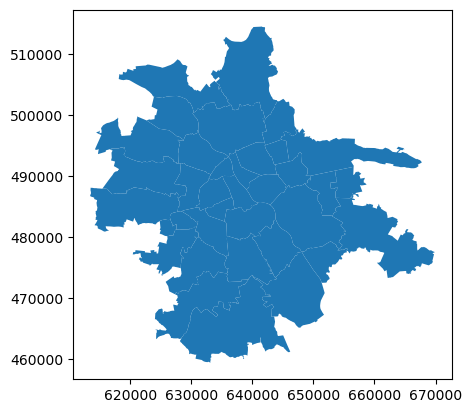

In [49]:
adja_gdf.plot();

In [89]:
adja_gdf['area_km2'] = adja_gdf.geometry.area / 1_000_000

In [93]:
adja_gdf[['NAZWA', 'area_km2']].sort_values(by="area_km2", ascending=False)

,NAZWA,area_km2
14,Piaseczno,128.126660
28,Wiązowna,102.045409
11,Nieporęt,95.972297
25,Wawer,79.642792
31,Zielonka,79.411130
6,Konstancin-Jeziorna,78.510962
1,Białołęka,72.933762
13,Ożarów Mazowiecki,71.173012
7,Lesznowola,69.230918
3,Izabelin,64.943917


#### 6. Plots & summaries

In [63]:
all_municipalities_trans_df["rodzaj_nieruchomosci"].unique()

<StringArray>
[   'nieruchomoscGruntowaZabudowana', 'nieruchomoscGruntowaNiezabudowana',
             'nieruchomoscBudynkowa',              'nieruchomoscLokalowa',
                                 nan]
Length: 5, dtype: str

In [64]:
property_type_mapping = {
    'nieruchomoscGruntowaZabudowana': 'land_with_building',
    'nieruchomoscGruntowaNiezabudowana': 'land',
    'nieruchomoscBudynkowa': 'building',
    'nieruchomoscLokalowa': 'appartment'
}

In [65]:
all_municipalities_trans_df["rodzaj_nieruchomosci"] = all_municipalities_trans_df["rodzaj_nieruchomosci"].map(property_type_mapping)

In [94]:
all_municipalities_trans_df["rodzaj_nieruchomosci"].value_counts()

rodzaj_nieruchomosci
appartment            35377
land                  30036
land_with_building    24346
building                224
Name: count, dtype: int64

In [67]:
property_type_hm = pd.crosstab(all_municipalities_trans_df["nazwa_gminy"], all_municipalities_trans_df["rodzaj_nieruchomosci"])

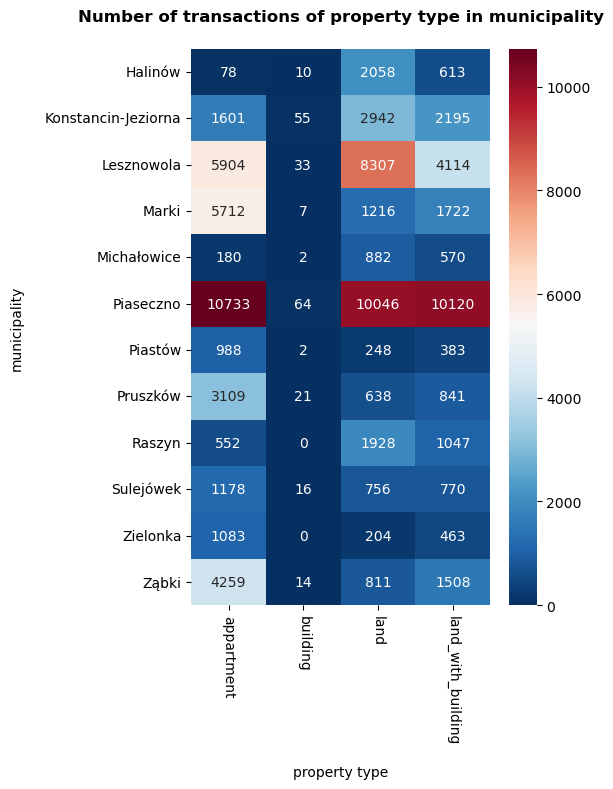

In [88]:
plt.figure(figsize=(6, 8))

sns.heatmap(property_type_hm,
            annot=True,
            fmt="d",
            cmap="RdBu_r")

plt.xlabel("property type", labelpad=15)
plt.ylabel("municipality", labelpad=15)
plt.xticks(rotation=270)
plt.title("Number of transactions of property type in municipality", fontweight="bold", pad=20)
plt.tight_layout()
plt.show();

Piaseczno is the place with the highest number of transactions, but it shouldn't be a surprise since it is the larges of analyzed municipalities. Even though the municipalities are located at the outskirs of Warsaw, there are still surprisingly many transactions of appartments. Second most popular property type is land, than land with building.

Let's see if there is any dependency on the month

In [96]:
all_municipalities_trans_df['month'] = all_municipalities_trans_df['data_transakcji'].dt.month

In [99]:
all_municipalities_trans_df['month'].value_counts().sort_index()

month
1     7395
2     7015
3     8127
4     8031
5     7299
6     8109
7     7702
8     6708
9     7609
10    7843
11    6990
12    8602
Name: count, dtype: int64

In [103]:
month_ptype_counts = (
    all_municipalities_trans_df.groupby(["rodzaj_nieruchomosci", "month"])
      .size()
      .unstack(fill_value=0)
)

In [111]:
def month_to_season(month):
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    else:
        return "Fall"

In [112]:
all_municipalities_trans_df['season'] = all_municipalities_trans_df['month'].apply(month_to_season)

In [113]:
season_colors = {
    "Winter": "#1f77b4", 
    "Spring": "#2ca02c",
    "Summer": "#ff7f0e",
    "Fall":   "#d62728"
}

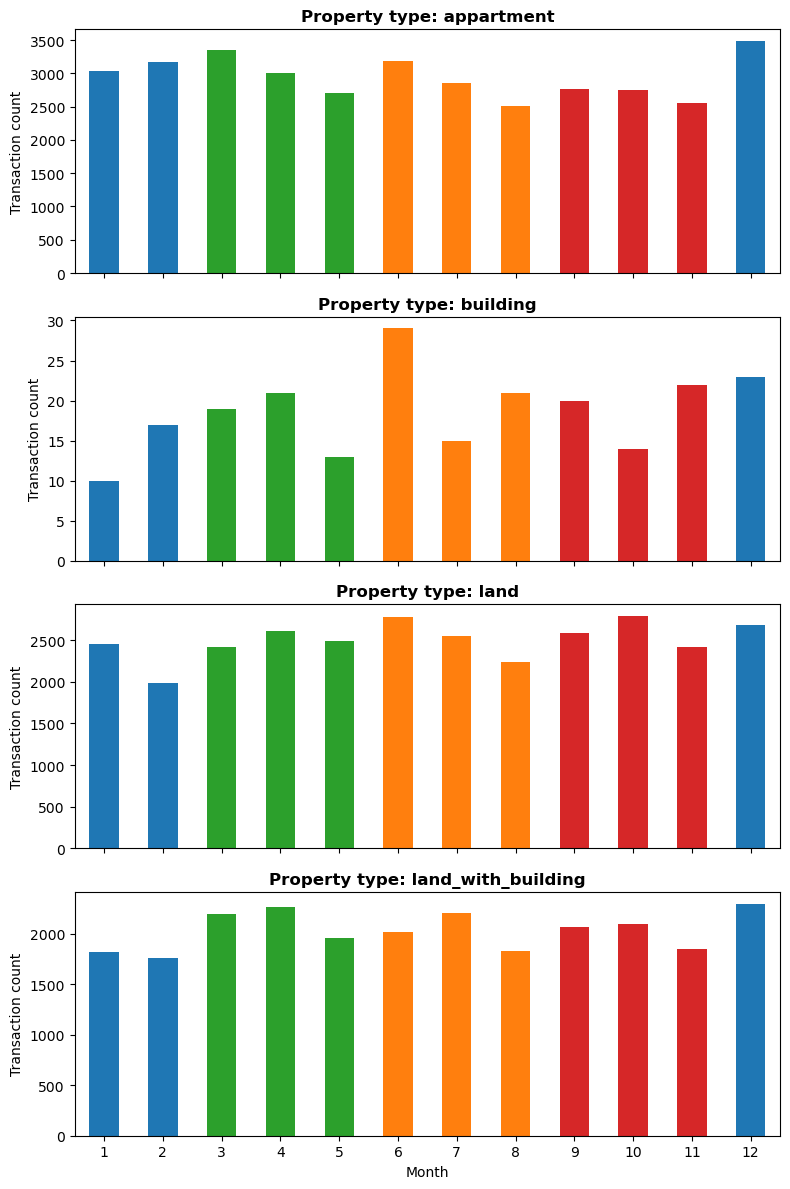

In [114]:
property_types = month_ptype_counts.index
n = len(property_types)

fig, axes = plt.subplots(n, 1, figsize=(8, 3*n), sharex=True)

if n == 1:
    axes = [axes]

for ax, pt in zip(axes, property_types):
    month_counts = month_ptype_counts.loc[pt]
    
    colors = [season_colors[month_to_season(m)] for m in month_counts.index]
    
    month_counts.plot(kind="bar", ax=ax, color=colors)
    
    ax.set_title(f"Property type: {pt}", fontweight="bold")
    ax.set_ylabel("Transaction count")
    ax.tick_params(axis='x', rotation=0)

plt.xlabel("Month")
plt.tight_layout()
plt.show();

The distribution over month, in general or when dividing into property type is rather uniform. There is only one little spike for buildings in June, but the overall number of transactions is very limited for this category. (For the sake of accuracy: I should have excluded data for 2020 and 2026 since they are not complete.)

In [95]:
all_municipalities_trans_df['rodzaj_transakcji'].value_counts()

rodzaj_transakcji
wolnyRynek                           90618
sprzedazPrzetargowa                    254
sprzedazBezprzetargowa                 232
sprzedazWPostepowaniuEgzekucyjnym      135
sprzedazZBonifikata                     43
sprzedazNaCelPubliczny                  26
Name: count, dtype: int64

Not surprisingly free market transactions dominate the dataset.